In [1]:
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import tqdm
# import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# from matplotlib.animation import FuncAnimation
# from IPython import display

# from IPython import display
import time

Let's introduce the Pauli Matrixes for the projections purposes, indeed they would be used in order to caracterise the resulting state of a mesurement

In [2]:
# I = np.matrix([[1 , 0],[0 , 1]])
# sx = np.matrix([[0 , 1] , [1 , 0]])
# sy = np.matrix([[0 , -1j] , [1j , 0]])
# sz = np.matrix([[1,0] , [0,-1]])

I = np.matrix([[1 , 0],[0 , 1]])
sx = np.matrix([[0 , 1] , [1 , 0]])
sy = np.matrix([[0 , -1j] , [1j , 0]])
sz = np.matrix([[1,0] , [0,-1]])

Pauli_matrices = [I, sx, sy, sz]

In [3]:
ni = 10
nx = 10
ny = 10
nz = 10

In [4]:
def Likelyhood_r(r, list_Mesure, list_instance):
    prod = 1
    N = len(list_instance)
    sx = np.matrix([[0 , 1] , [1 , 0]])
    sy = np.matrix([[0 , -1j] , [1j , 0]])
    sz = np.matrix([[1,0] , [0,-1]])
    s = [sx, sy, sz]
    rho = np.matrix([[1 , 0],[0 , 1]])/2 + r[0]*sx /2 + r[1]*sy/2 + r[2]*sz/2 
    for i in range(N):
        prod *= np.trace(np.matmul(rho, list_Mesure[i]) ) **  list_instance[i]
    return prod

In [5]:
def MCMC_naif( list_Mesure, list_instance, N, var, r0 ):
    parcour = [ [0,0,0] for k in range(N)]
    r = r0/np.linalg.norm(r0, ord=None, axis=None, keepdims=False)
    Likely = Likelyhood_r(r, list_Mesure, list_instance)
    Acceptance_count = 0 # to count in the end the acceptance rate
    for i in range(N):
        parcour[i] = r # at each iteration I store the vector r
        dr = np.random.normal(loc=0.0, scale=var, size=(1,3)) # infenitisimal shift
        r2 = r + dr[0] # I need to put dr[0] to conserve the array shape, indeed dr is a matrix(1,3)
        r2 = r2/np.linalg.norm(r2, ord=None, axis=None, keepdims=False)
        Lik2 = Likelyhood_r(r2, list_Mesure, list_instance)
        ratio = Lik2/Likely 
        U = np.random.uniform(low=0.0, high=1.0, size=None)
        if U < ratio:  #I shift the position according to the MH algorithm
            r = r2
            Likely = Lik2
            Acceptance_count += 1
    return parcour, Acceptance_count/N

In [32]:
list,rate = MCMC_naif([np.matrix([[1/2 , 1/2],[1/2 , 1/2]]),np.matrix([[1/2 , -1/2],[-1/2 , 1/2]]),np.matrix([[1 , 0],[0 , 0]]),np.matrix([[0 , 0],[0 , 1]])], [30,0,15,15], 5000, 2, [0.5,0.5,0.5])

In [34]:
list,rate = MCMC_naif([H0, H1, U0, U1, E0, E1],
                      [75, 0, 29, 46, 35,40], 
                      5000, 2, 
                      [0.5,0.5,0.5])

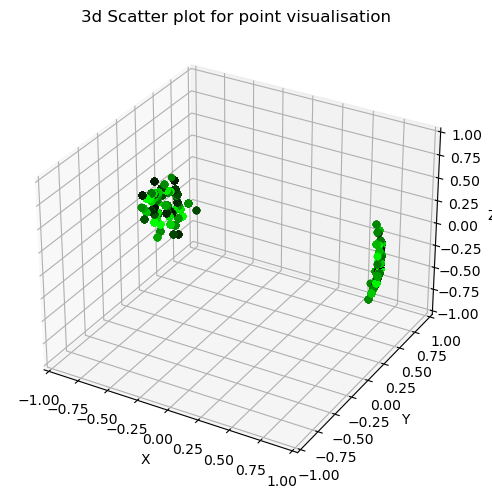

In [36]:
#plot with color
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
 
fig = plt.figure(constrained_layout=True)
# ax = p3.Axes3D(fig)
ax = plt.axes(projection='3d')
# Setting the axes properties
ax.set_xlim3d([-1.0, 1.0])
ax.set_xlabel('X')

ax.set_ylim3d([-1.0, 1.0])
ax.set_ylabel('Y')

ax.set_zlim3d([-1.0, 1.0])
ax.set_zlabel('Z')

ax.set_title('3D Test')

N = len(list)
Burn = 1000
 
# syntax for 3-D projection

for i in range(Burn, N):
    c = (0, (i-Burn)/(N-Burn), 0)
    # print(c)
    z = list[i][2]
    x = list[i][1]
    y = list[i][0]
    # xlist = np.append(xlist, x)
    # ylist = np.append(ylist, y)
    # zlist = np.append(zlist, z)
    ax.scatter(x, y, z, color = c)


# syntax for plotting
ax.set_title('3d Scatter plot for point visualisation')
plt.show()

In [16]:
type(list)

list

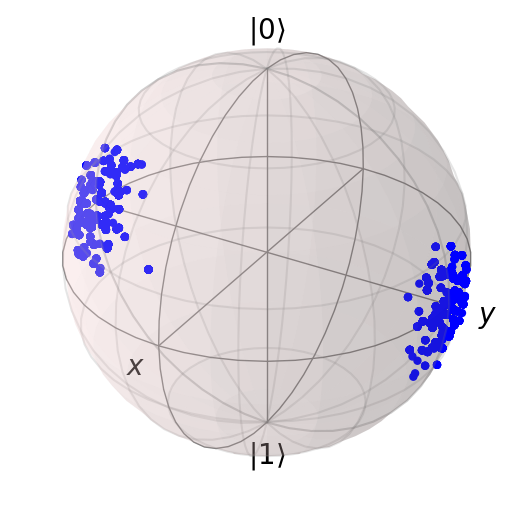

In [18]:
import qutip

# N = len(states)
# Burn = int(N*0.1)

# z = [states[i][2] for i in range(Burn,N)]
# x = [states[i][0] for i in range(Burn,N)]
# y = [states[i][1] for i in range(Burn,N)]

b = qutip.Bloch()

b.add_points([xlist, ylist, zlist])
b.show()

# Alternative version

In [3]:
I = np.matrix([[1 , 0],[0 , 1]])
sx = np.matrix([[0 , 1] , [1 , 0]])
sy = np.matrix([[0 , -1j] , [1j , 0]])
sz = np.matrix([[1,0] , [0,-1]])

Pauli_matrices = [I, sx, sy, sz]

In [4]:
def state_likelikood(states, measurement_matrices, outcomes, PauliM):
    Likelihood = 1
    rho = (1/2) * (PauliM[0] + states[0]*PauliM[1] + states[1]*PauliM[2] + states[2]*PauliM[3])
    for i in range(len(outcomes)):
        Likelihood *= np.trace(rho @ measurement_matrices[i]) **  outcomes[i]
    return Likelihood

In [5]:
def normalize_state(state):
    return state.copy()/np.linalg.norm(state.copy())

In [6]:
def MCMC_Step_by_Step( measurement_matrices, outcomes, 
                      N, var, initial_state, PauliM ):
    # b = qutip.Bloch()
    # b.point_color= ['b']
    # b.point_marker= ['o']

    points = [initial_state]
    normalized_state = normalize_state(initial_state)
    Likelihood = state_likelikood(normalized_state, measurement_matrices, 
                                  outcomes, PauliM)
    Acceptance_count = 0 # to count in the end the acceptance rate
    for i in tqdm.tqdm(range(N)):
        dr = np.random.normal(loc=0.0, scale=var, size=(1,3)) # infenitisimal shift
        new_state = normalized_state + dr[0] # I need to put dr[0] to conserve the array shape, indeed dr is a matrix(1,3)
        normalized_new_state = normalize_state(new_state)
        new_Likelihood = state_likelikood(normalized_new_state, 
                                          measurement_matrices, outcomes, PauliM)
        Likelihood_ratio = new_Likelihood/Likelihood 
        sample = np.random.uniform(low=0.0, high=1.0)
        if sample < Likelihood_ratio:  #I shift the position according to the MH algorithm
            normalized_state = normalized_new_state
            points.append(normalized_state)
            Likelihood = new_Likelihood
            Acceptance_count += 1
            # b.add_points(normalized_state)
            # b.save(f"./plots/{i}.png")
            # b.save(dirc="tmp")
    return points, Acceptance_count/N

In [7]:
# x, y, z
ex1 = [{'0': 75, '1': 0}, {'0': 29, '1': 46}, {'1': 35, '0': 40}]
# outcomes = [0] * ex1[0]['0'] + [1] * ex1[0]['1'] + [2] * ex1[1]['0'] + [3] * ex1[1]['1'] + [4] * ex1[2]['0'] + [5] * ex1[2]['1']

S0 = np.array([[1],[0]])
S1 = np.array([[0],[1]])

ρ0 = S0 @ S0.T
ρ1 = S1 @ S1.T

E0 = np.matrix([[1 , 0],[0 , 0]])
E1 = np.matrix([[0 , 0],[0 , 1]])

H = 1/np.sqrt(2) * np.matrix([[1 , 1],[1 , -1]])
H0 = H @ S0 @ S0.T @ H.H
H1 = H @ S1 @ S1.T @ H.H

U = 1/np.sqrt(2) * np.matrix([[1 , -1j],[1 , 1j]])
U0 = U @ S0 @ S0.T @ U.H
U1 = U @ S1 @ S1.T @ U.H

Ui = np.linalg.inv(U)
U0i = Ui @ S0 @ S0.T @ Ui.H
U1i = Ui @ S1 @ S1.T @ Ui.H

In [8]:
H0, U0i

(matrix([[0.5, 0.5],
         [0.5, 0.5]]),
 matrix([[0.5+0.j , 0. -0.5j],
         [0. +0.5j, 0.5+0.j ]]))

In [9]:
H1, U1i

(matrix([[ 0.5, -0.5],
         [-0.5,  0.5]]),
 matrix([[0.5+0.j , 0. +0.5j],
         [0. -0.5j, 0.5+0.j ]]))

In [10]:
states,rates = MCMC_Step_by_Step([H0, H1, U0i, U1i, E0, E1], [75, 0, 29, 46, 35, 40], 2000, 1, [0.5,0.5,0.5], Pauli_matrices)

100%|████████████████████████████████████| 2000/2000 [00:00<00:00, 22272.93it/s]


In [11]:
rates

0.035

In [12]:
import qutip

N = len(states)
Burn = int(N*0.2)

fig=plt.figure(figsize=[10,10])


z = [states[i][2] for i in range(Burn,N)]
x = [states[i][0] for i in range(Burn,N)]
y = [states[i][1] for i in range(Burn,N)]

b = qutip.Bloch3d()
b.point_color=["r"]
b.add_points([x, y, z], alpha=1)
b.add_vectors(np.mean([x,y,z],axis=1))
b.show()

<Figure size 1000x1000 with 0 Axes>

## End of rotations

In [27]:
b.save(name="MCMC.PDF")

In [58]:
def measure(ρ):
    Id = np.matrix([[1 , 0],[0 , 1]])
    sx = np.matrix([[0 , 1] , [1 , 0]])
    sy = np.matrix([[0 , -1j] , [1j , 0]])
    sz = np.matrix([[1,0] , [0,-1]])    
    x = np.trace(np.dot(ρ, sx)).real
    y = np.trace(np.dot(ρ, sy)).real
    z = np.trace(np.dot(ρ, sz)).real
    return [x, y, z]

In [59]:
def Haar_sampling(N):
    l =[0] * N
    for i in range(N):
        M = np.random.normal( size = ( 2, 2 ) ) + 1j * np.random.normal( size = ( 2, 2 ) )
        X = M.dot(M.conj().T)
        l[i] = X/ np.trace(X)
    return l

In [117]:
import qutip

N = 750
Rhos = [Haar_sampling(1) for i in range(1, N)]

# fig, ax = plt.subplots(figsize=(5, 5))
# ax.axis("square")


# ax.annotate('ASDASD', xy=(0.1, 0.9), xytext=(0.1, 0.7), xycoords='axes fraction',
#             fontsize=15, color='r', ha='center',)

coordinates = [measure(rho) for rho in Rhos]

z0 = [coordinates[i][2] for i in range(0,N-1)]
x0 = [coordinates[i][0] for i in range(0,N-1)]
y0 = [coordinates[i][1] for i in range(0,N-1)]

b = qutip.Bloch(fig=fig)
# b.xlabel = ["|+>", ""]
# b.xlabel = ["|+>", ""]
b.point_color = ["r"]

b.add_points([x0, y0, z0], alpha=0.3)
# b.plot_points(coordinates)
# b.show()
# plt.show()
b.save("Haar.pdf")

Now let plot the point on a sphere

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from skspatial.objects import Sphere
# import mpl_toolkits.mplot3d.axes3d as p3
# import matplotlib.animation as animation
 
sphere = Sphere([0, 0, 0], 1)
    

    
fig = plt.figure(figsize=(8,8), constrained_layout=True)
# ax = p3.Axes3D(fig)
ax = plt.axes(projection='3d')
# ax.dist = 13
# fig.gca(projection="3d")

# Setting the axes properties
ax.set_xlim3d([-1.0, 1.0])
ax.set_xlabel('X')

ax.set_ylim3d([-1.0, 1.0])
ax.set_ylabel('Y')

ax.set_zlim3d([-1.0, 1.0])
ax.set_zlabel('Z')
 
# syntax for 3-D projection
"""for i in range(len(list)):
  z = list[i][2]
  x = list[i][0]
  y = list[i][1]
  ax.scatter(x, y, z)"""
N = len(list)
Burn = 1000

z = [list[i][2] for i in range(Burn,N)]
x = [list[i][0] for i in range(Burn,N)]
y = [list[i][1] for i in range(Burn,N)]
ax.scatter(x, y, z, c='r', s=28)
sphere.plot_3d(ax, alpha=0.2)

# syntax for plotting
ax.set_title('MCMC State estimation')
plt.show()

ModuleNotFoundError: No module named 'skspatial'

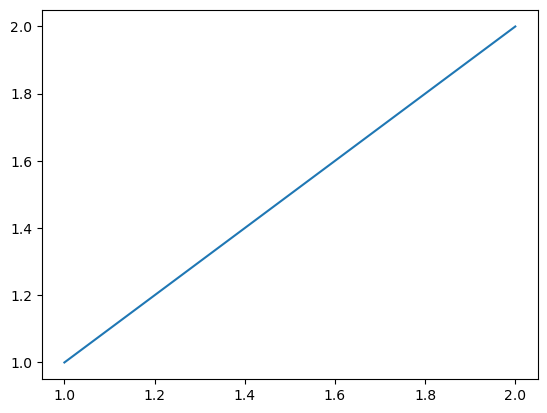

In [17]:
plt.plot([1,2] , [1,2])
plt.show()

In [15]:
print(plt.get_backend())

module://matplotlib_inline.backend_inline


(0, 0.0, 0)
(0, 0.00025, 0)
(0, 0.0005, 0)
(0, 0.00075, 0)
(0, 0.001, 0)
(0, 0.00125, 0)
(0, 0.0015, 0)
(0, 0.00175, 0)
(0, 0.002, 0)
(0, 0.00225, 0)
(0, 0.0025, 0)
(0, 0.00275, 0)
(0, 0.003, 0)
(0, 0.00325, 0)
(0, 0.0035, 0)
(0, 0.00375, 0)
(0, 0.004, 0)
(0, 0.00425, 0)
(0, 0.0045, 0)
(0, 0.00475, 0)
(0, 0.005, 0)
(0, 0.00525, 0)
(0, 0.0055, 0)
(0, 0.00575, 0)
(0, 0.006, 0)
(0, 0.00625, 0)
(0, 0.0065, 0)
(0, 0.00675, 0)
(0, 0.007, 0)
(0, 0.00725, 0)
(0, 0.0075, 0)
(0, 0.00775, 0)
(0, 0.008, 0)
(0, 0.00825, 0)
(0, 0.0085, 0)
(0, 0.00875, 0)
(0, 0.009, 0)
(0, 0.00925, 0)
(0, 0.0095, 0)
(0, 0.00975, 0)
(0, 0.01, 0)
(0, 0.01025, 0)
(0, 0.0105, 0)
(0, 0.01075, 0)
(0, 0.011, 0)
(0, 0.01125, 0)
(0, 0.0115, 0)
(0, 0.01175, 0)
(0, 0.012, 0)
(0, 0.01225, 0)
(0, 0.0125, 0)
(0, 0.01275, 0)
(0, 0.013, 0)
(0, 0.01325, 0)
(0, 0.0135, 0)
(0, 0.01375, 0)
(0, 0.014, 0)
(0, 0.01425, 0)
(0, 0.0145, 0)
(0, 0.01475, 0)
(0, 0.015, 0)
(0, 0.01525, 0)
(0, 0.0155, 0)
(0, 0.01575, 0)
(0, 0.016, 0)
(0, 0.01625, 

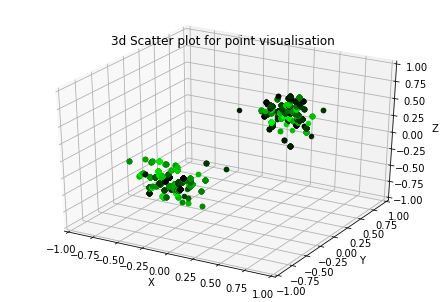

In [29]:
#plot with color
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
 
fig = plt.figure()
ax = p3.Axes3D(fig)
# Setting the axes properties
ax.set_xlim3d([-1.0, 1.0])
ax.set_xlabel('X')

ax.set_ylim3d([-1.0, 1.0])
ax.set_ylabel('Y')

ax.set_zlim3d([-1.0, 1.0])
ax.set_zlabel('Z')

ax.set_title('3D Test')

N = len(list)
Burn = 1000
 
# syntax for 3-D projection
for i in range(Burn, N):
  c = (0, (i-Burn)/(N-Burn), 0)
  print(c)
  z = list[i][2]
  x = list[i][0]
  y = list[i][1]
  ax.scatter(x, y, z, color = c)


# syntax for plotting
ax.set_title('3d Scatter plot for point visualisation')
plt.show()

# Rotations

In [50]:
def measure(ρ):
    Id = np.matrix([[1 , 0],[0 , 1]])
    sx = np.matrix([[0 , 1] , [1 , 0]])
    sy = np.matrix([[0 , -1j] , [1j , 0]])
    sz = np.matrix([[1,0] , [0,-1]])    
    x = np.trace(np.dot(ρ, sx)).real
    y = np.trace(np.dot(ρ, sy)).real
    z = np.trace(np.dot(ρ, sz)).real
    return [x, y, z]

In [62]:
# x, y, z
ex1 = [{'0': 75, '1': 0}, {'0': 29, '1': 46}, {'1': 35, '0': 40}]
# outcomes = [0] * ex1[0]['0'] + [1] * ex1[0]['1'] + [2] * ex1[1]['0'] + [3] * ex1[1]['1'] + [4] * ex1[2]['0'] + [5] * ex1[2]['1']

S0 = np.array([[1],[0]])
S1 = np.array([[0],[1]])

ρ0 = S0 @ S0.T
ρ1 = S1 @ S1.T

E0 = np.matrix([[1 , 0],[0 , 0]])
E1 = np.matrix([[0 , 0],[0 , 1]])

H = 1/np.sqrt(2) * np.matrix([[1 , 1],[1 , -1]])
H0 = H @ S0 @ S0.T @ H.H
H1 = H @ S1 @ S1.T @ H.H

U = 1/np.sqrt(2) * np.matrix([[1 , -1j],[1 , 1j]])
U0 = U @ S0 @ S0.T @ U.H
U1 = U @ S1 @ S1.T @ U.H

Ui = np.linalg.inv(U)
U0i = Ui @ S0 @ S0.T @ Ui.H
U1i = Ui @ S1 @ S1.T @ Ui.H

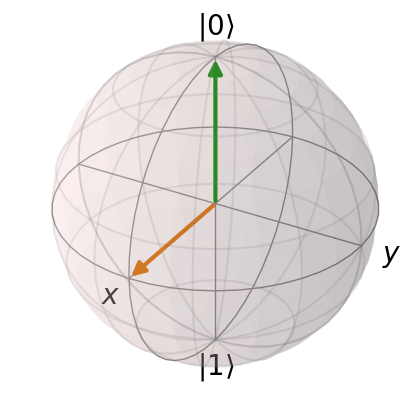

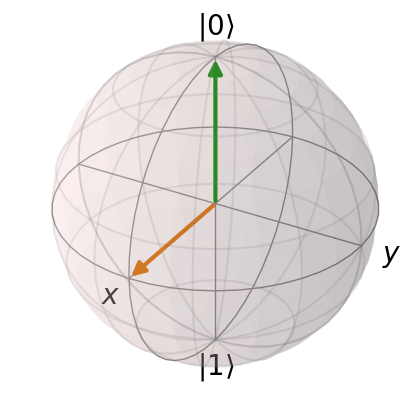

In [57]:
import qutip

fig = plt.figure(figsize=(4,4))
b = qutip.Bloch(fig=fig)
b.point_color = ["r"]

b.add_vectors(measure(ρ0))
b.add_vectors(measure(H@ρ0@H.H))
# b.add_vectors(measure(U@ρ0@U.H))
# b.plot_points(coordinates)
b.show()
# plt.show()
# b.save("Haar.pdf")

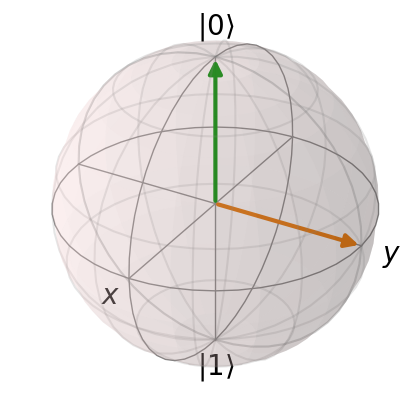

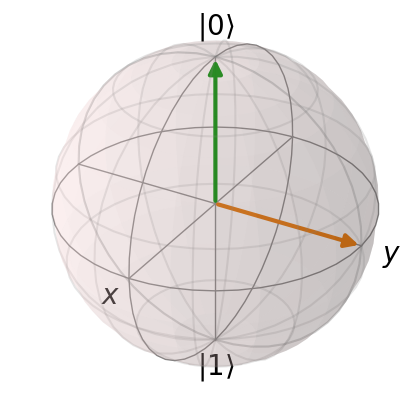

In [61]:
import qutip

fig = plt.figure(figsize=(4,4))
b = qutip.Bloch(fig=fig)
b.point_color = ["r"]

b.add_vectors(measure(ρ0))
b.add_vectors(measure(Ui@ρ0@Ui.H))
# b.add_vectors(measure(U@ρ0@U.H))
# b.plot_points(coordinates)
b.show()
# plt.show()
# b.save("Haar.pdf")

In [99]:
fig = plt.figure(figsize=(4,4))
b = qutip.Bloch3d()
b.point_color = ["r"]

b.add_vectors([0.5, 0.5, 0.5])
# b.add_vectors(measure(Ui@ρ0@Ui.H))
# b.add_vectors(measure(U@ρ0@U.H))
# b.plot_points(coordinates)
b.show()
# plt.show()
# b.save("Haar.pdf")

<Figure size 400x400 with 0 Axes>

In the section, given the path followed by the MCMC, I aim to make a gif in order to visualise the plot distribution througt time